# Feature Importance 

XGBoost의 gain, cover, weight 방법과 Shap을 사용하여 특성 중요도 계산

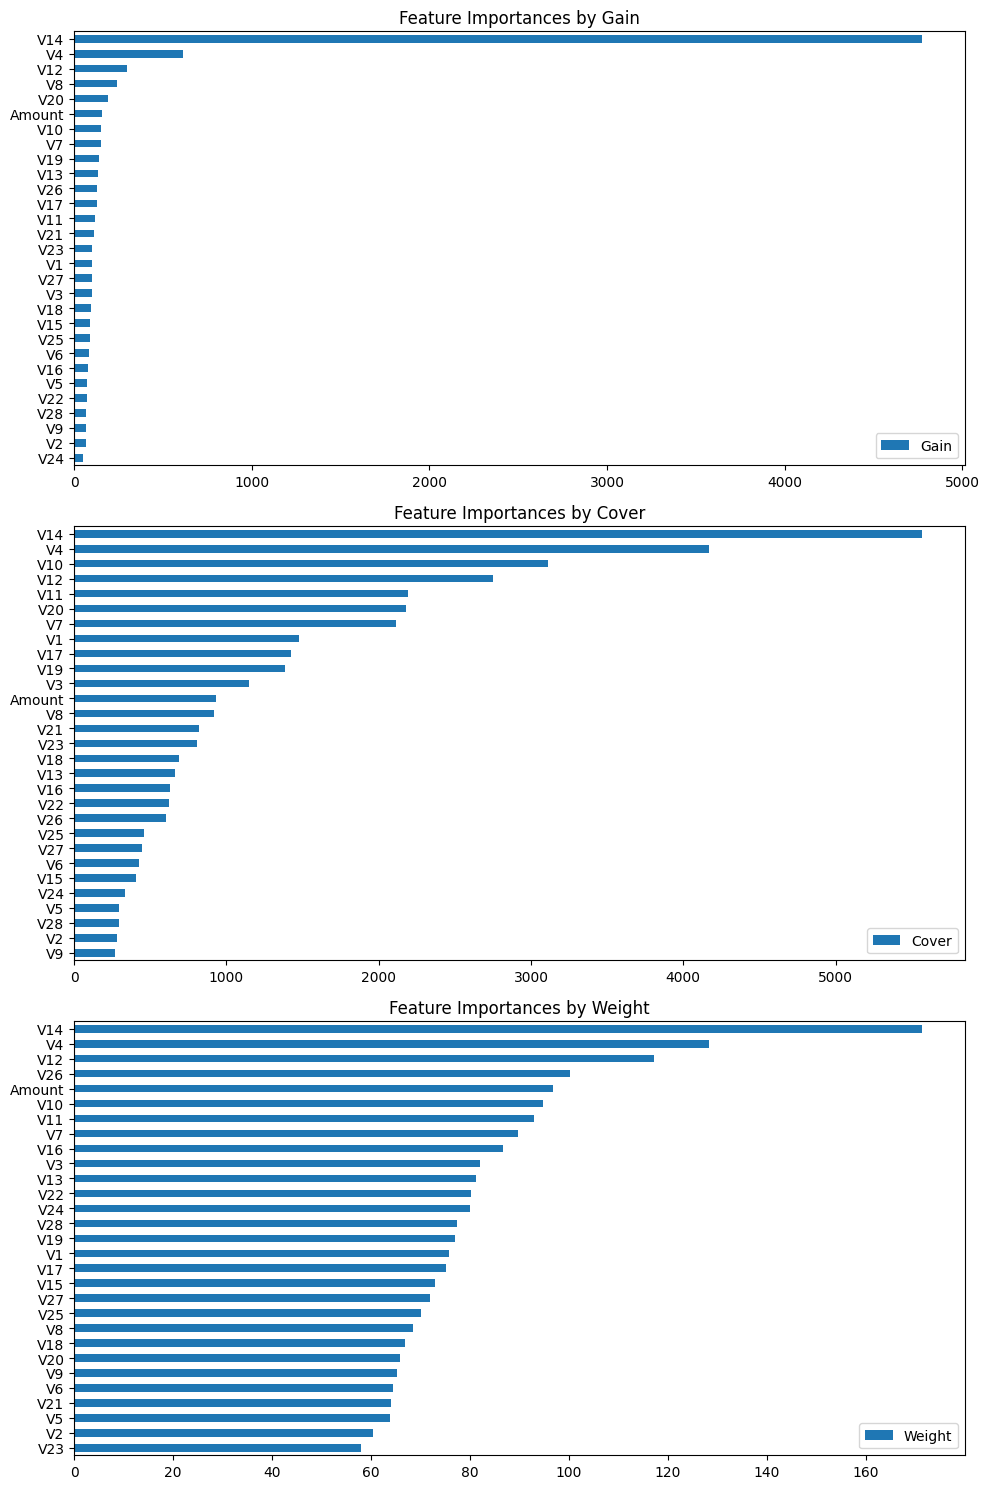

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, resample
import warnings
warnings.filterwarnings('ignore')

def make_train_dataset(X_train, seed):
    # upsampling abnormal data
    X_train_normal = X_train[X_train.Class==0]
    X_train_abnormal = X_train[X_train.Class==1]
    
    X_abnormal_res = resample(X_train_abnormal, replace=True, n_samples=X_train_normal.shape[0], random_state=seed)
    X_train = pd.concat([X_train_normal, X_abnormal_res])
    
    y_train = X_train.Class
    X_train = X_train.drop('Class', axis=1)
    
    # shuffle 
    X_res, y_res = shuffle(X_train, y_train, random_state=seed)
    
    return X_res, y_res


# 데이터 불러오기 및 전처리
data = pd.read_csv('./creditcard.csv')
data.drop(['Time'], axis=1, inplace=True)

# 훈련 데이터와 테스트 데이터로 분할
# 데이터프레임 컬럼 이름을 위함
X_train, X_test, y_train, y_test = train_test_split(data.drop('Class', axis=1), data['Class'], test_size=0.25, random_state=42)

# 특성 중요도를 저장할 데이터프레임 초기화
importances_gain = pd.DataFrame(index=X_train.columns, columns=['Gain']).fillna(0)
importances_cover = pd.DataFrame(index=X_train.columns, columns=['Cover']).fillna(0)
importances_weight = pd.DataFrame(index=X_train.columns, columns=['Weight']).fillna(0)

# XGBoost 모델을 50번 실행
for seed in range(50):

    data = pd.read_csv('./creditcard.csv')
    data.drop('Time', axis=1, inplace=True)
    X_train, X_test = train_test_split(data, stratify=data.Class, test_size=0.25, random_state=seed)
    
    ss = StandardScaler()
    X_train['Amount'] = ss.fit_transform(X_train['Amount'].values.reshape(-1, 1))
    X_test['Amount'] = ss.transform(X_test['Amount'].values.reshape(-1, 1))
    
    # 업샘플링 
    X_res, y_res = make_train_dataset(X_train, seed)
    
    model = xgb.XGBClassifier(seed=seed)
    model.fit(X_res, y_res)

    # 각 방식으로 특성 중요도 계산 및 누적
    gain = model.get_booster().get_score(importance_type='gain')
    cover = model.get_booster().get_score(importance_type='cover')
    weight = model.get_booster().get_score(importance_type='weight')

    for feature in X_res.columns:
        importances_gain.at[feature, 'Gain'] += gain.get(feature, 0)
        importances_cover.at[feature, 'Cover'] += cover.get(feature, 0)
        importances_weight.at[feature, 'Weight'] += weight.get(feature, 0)

# 특성 중요도 평균 계산
importances_gain /= 50
importances_cover /= 50
importances_weight /= 50

# 특성 중요도 시각화
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

importances_gain.sort_values(by='Gain', ascending=True).plot(kind='barh', ax=axes[0], title='Feature Importances by Gain')
importances_cover.sort_values(by='Cover', ascending=True).plot(kind='barh', ax=axes[1], title='Feature Importances by Cover')
importances_weight.sort_values(by='Weight', ascending=True).plot(kind='barh', ax=axes[2], title='Feature Importances by Weight')

plt.tight_layout()
plt.show()


In [4]:
# 마지막 반복문에서의 X_test
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
161346,-1.182510,-0.276414,1.838473,-2.108407,0.522110,-0.338380,0.771815,-0.106098,0.310639,-1.215767,...,0.168456,0.254445,-0.159893,0.634677,0.542826,1.158547,-0.312794,-0.171342,0.075398,0
117843,-1.660165,0.948201,1.547104,-1.502118,0.266590,-0.599320,1.007740,-0.484323,0.875155,0.789656,...,-0.284582,0.017754,0.058002,0.141854,-0.251148,0.690703,0.068058,-0.057973,-0.250232,0
241752,-1.097906,0.942704,1.390230,0.319363,0.029975,0.319577,0.318942,0.720510,0.277932,-1.202814,...,-0.537839,-1.660984,-0.158593,-0.865348,0.509678,-0.926715,-0.065278,-0.007540,-0.246710,0
153200,1.989780,0.201702,-1.628933,0.778573,0.495384,-0.459326,-0.106196,-0.166018,1.738126,-0.901647,...,-0.123966,0.154198,0.064592,0.651300,0.071188,0.541508,-0.072931,-0.036998,-0.309596,0
267337,-7.464959,6.689199,-4.861434,-1.223730,-3.088562,-1.989200,-1.933534,3.383301,2.396026,4.747463,...,0.007957,1.253502,0.510312,0.509358,0.176068,-0.388712,-0.323224,-1.056836,-0.345649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140444,-1.376245,0.899477,1.620318,0.297977,0.193500,-0.116760,0.258325,0.713065,-0.665712,-0.923074,...,0.062016,0.020455,-0.311043,0.195845,0.600169,-0.423179,-0.071839,-0.057383,-0.345214,0
41724,-1.119661,-0.738551,0.332932,-1.059003,1.977831,3.957213,0.954796,0.377935,-0.008561,-0.101815,...,-0.183631,-0.177153,0.647316,1.006513,-0.230403,0.224821,-0.182783,-0.423400,0.620042,0
242843,-0.491077,1.398775,-0.362764,-0.288908,0.660540,-1.004669,1.088589,0.011925,-0.603402,-0.835458,...,0.199969,0.612344,-0.151413,1.207540,-0.106766,-0.307753,-0.092408,0.127423,-0.337299,0
71772,-7.940874,2.569572,-2.711180,3.769463,-4.801327,1.250684,-4.690384,2.123436,-2.356189,-1.221653,...,-0.546101,0.863812,-0.169225,0.298368,-0.070095,0.243338,-2.221155,-0.940544,-0.346164,0


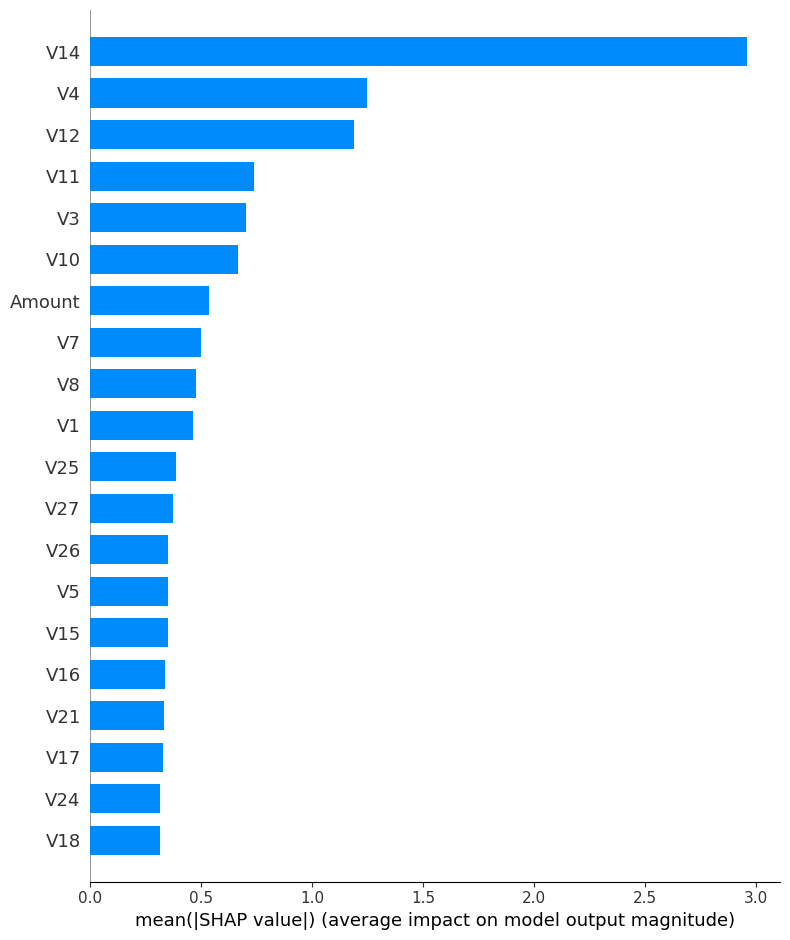

In [5]:
import shap

# SHAP를 계산하기 위해 마지막 XGBoost 모델 사용
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test.iloc[:, :-1])

shap.summary_plot(shap_values, X_test.iloc[:, :-1], plot_type="bar")